<a href="https://colab.research.google.com/github/Inbal-Schekler/Jubaan_Interview/blob/main/Interview_assignment_Inbal_Schekler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports


In [1]:
import pathlib
import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
import os
import glob
import cv2
from keras import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from google.colab.patches import cv2_imshow
from matplotlib import pyplot


## Dataset


Download the images and unzip the files

In [2]:
!wget http://www.ai.mit.edu/courses/6.899/lectures/faces.tar.gz

--2022-11-27 06:42:20--  http://www.ai.mit.edu/courses/6.899/lectures/faces.tar.gz
Resolving www.ai.mit.edu (www.ai.mit.edu)... 128.30.2.128
Connecting to www.ai.mit.edu (www.ai.mit.edu)|128.30.2.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27512619 (26M) [application/x-gzip]
Saving to: ‘faces.tar.gz’

faces.tar.gz        100%[===================>]  26.24M  48.8MB/s    in 0.5s    

2022-11-27 06:42:21 (48.8 MB/s) - ‘faces.tar.gz’ saved [27512619/27512619]



In [3]:
!tar -xvzf faces.tar.gz && tar -xvzf  face.test.tar.gz && tar -xvzf face.train.tar.gz


Streaming output truncated to the last 5000 lines.
train/face/face01979.pgm
train/face/face01980.pgm
train/face/face01981.pgm
train/face/face01982.pgm
train/face/face01983.pgm
train/face/face01984.pgm
train/face/face01985.pgm
train/face/face01986.pgm
train/face/face01987.pgm
train/face/face01988.pgm
train/face/face01989.pgm
train/face/face01990.pgm
train/face/face01991.pgm
train/face/face01992.pgm
train/face/face01993.pgm
train/face/face01994.pgm
train/face/face01995.pgm
train/face/face01996.pgm
train/face/face01997.pgm
train/face/face01998.pgm
train/face/face01999.pgm
train/face/face02000.pgm
train/face/face02001.pgm
train/face/face02002.pgm
train/face/face02003.pgm
train/face/face02004.pgm
train/face/face02005.pgm
train/face/face02006.pgm
train/face/face02007.pgm
train/face/face02008.pgm
train/face/face02009.pgm
train/face/face02010.pgm
train/face/face02011.pgm
train/face/face02012.pgm
train/face/face02013.pgm
train/face/face02014.pgm
train/face/face02015.pgm
train/face/face02016.pgm

Explore the dataset

In [4]:
train_face = glob.glob ('/content/train/face/*pgm')
train_non_f = glob.glob ('/content/train/non-face/*pgm')

test_face = glob.glob ('/content/test/face/*pgm')
test_non_f = glob.glob ('/content/test/non-face/*pgm')


print('total training face images:', len(train_face))
print('total training non-face images:', len(train_non_f))

print('total testing face images:', len(test_face))
print('total testing non-face images:', len(test_non_f))
print("--")
print("Total training images:", len(train_face)+ len(train_non_f))
print("Total testing images:", len(test_face) + len(test_non_f))


total training face images: 2429
total training non-face images: 4548
total testing face images: 472
total testing non-face images: 23573
--
Total training images: 6977
Total testing images: 24045


Visualize the face images

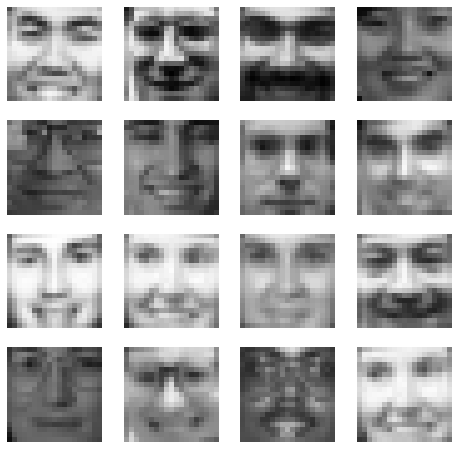

In [5]:
fig=plt.figure(figsize=(8, 8))
rows, cols = 4, 4

for j in range(0, cols*rows):
  fig.add_subplot(rows, cols, j+1)
  img = cv2.imread(train_face[j])
  plt.imshow(img)
  plt.axis("off")
plt.show()


Visualize the non-face images

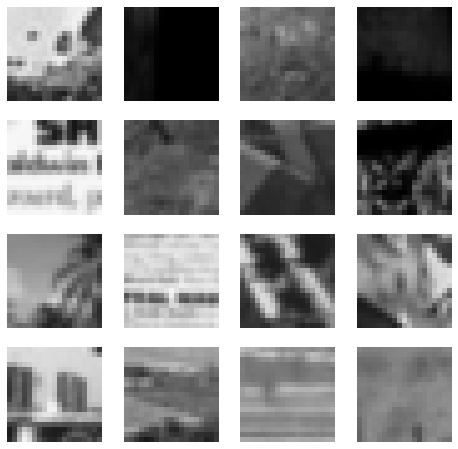

In [6]:
fig=plt.figure(figsize=(8, 8))
rows, cols = 4, 4

for j in range(0, cols*rows):
  fig.add_subplot(rows, cols, j+1)
  img = cv2.imread(train_non_f[j])
  plt.imshow(img)
  plt.axis("off")
plt.show()


##Geneartors

In [8]:
def image_generator(files, batch_size=32, sz = (19,19)):
    while True:

        # extract a random batch
        batch = np.random.choice(files, size=batch_size)

        # variables for collecting batches of inputs and outputs
        batch_x = []
        batch_y = []

        for f in batch:

            img = cv2.imread(f,-1)
            img = np.array (img) 


            batch_x.append(img)
            if os.path.dirname(f).split ('/')[-1]=="face":
              batch_y.append(1)
            else:
              batch_y.append (0)

           
        # preprocess a batch of images 
        batch_x = np.array(batch_x) / 255.
        batch_y = np.array(batch_y)

      

        yield (batch_x, batch_y)


In [9]:
train_list = glob.glob ('/content/train/*/*pgm')
test_list = glob.glob ('/content/test/*/*pgm')

In [10]:
train_generator = image_generator(train_list)
test_generator  = image_generator(test_list)

x, y= next(train_generator)
print (x.shape)
print(y.shape)

(32, 19, 19)
(32,)


## The model

In [24]:
model = Sequential([
   layers.Conv2D(16, 3, activation='relu', padding='same',input_shape=(19,19,1)),
   layers.MaxPooling2D(),

   layers.Conv2D(32, 3, activation='relu',padding='same'),
   layers.MaxPooling2D(),

    tf.keras.layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation ='sigmoid')
])

In [25]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 19, 19, 16)        160       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 9, 9, 16)         0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 9, 9, 32)          4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 4, 4, 32)          0         
                                                                 
 flatten_4 (Flatten)         (None, 512)              

In [13]:
#Add checkpoints 
from keras.callbacks import ModelCheckpoint

filepath = 'my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'

checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True,save_weights_only=True)
callbacks_list = [checkpoint]

Training the model

In [26]:
batch_size = 32
epochs = 10


train_steps = len(train_list) //batch_size
test_steps = len(test_list) //batch_size


history = model.fit(train_generator, 
                    epochs = epochs, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps, shuffle=True,
                    callbacks = callbacks_list)

Epoch 1/10
217/218 [============================>.] - ETA: 0s - loss: 0.2901 - accuracy: 0.8859
Epoch 1: val_loss did not improve from 0.06411
218/218 [==============================] - 15s 66ms/step - loss: 0.2891 - accuracy: 0.8865 - val_loss: 0.2638 - val_accuracy: 0.9005
Epoch 2/10
218/218 [==============================] - ETA: 0s - loss: 0.1092 - accuracy: 0.9632
Epoch 2: val_loss did not improve from 0.06411
218/218 [==============================] - 13s 58ms/step - loss: 0.1092 - accuracy: 0.9632 - val_loss: 0.0905 - val_accuracy: 0.9742
Epoch 3/10
217/218 [============================>.] - ETA: 0s - loss: 0.0572 - accuracy: 0.9823
Epoch 3: val_loss did not improve from 0.06411
218/218 [==============================] - 12s 56ms/step - loss: 0.0573 - accuracy: 0.9821 - val_loss: 0.0857 - val_accuracy: 0.9740
Epoch 4/10
218/218 [==============================] - ETA: 0s - loss: 0.0442 - accuracy: 0.9854
Epoch 4: val_loss did not improve from 0.06411
218/218 [====================

###Performance figures







(0.0, 0.3)

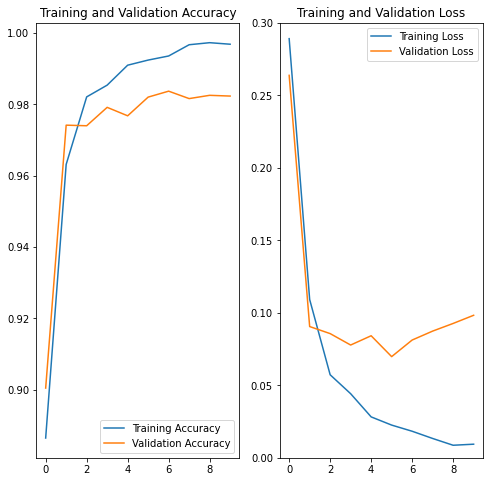

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylim ([0,0.3])


Performance results

In [28]:
def image_array (files):
    x_np = []
    y_np = []

    for f in files:

        img = cv2.imread(f,-1)
        img = np.array (img) 


        x_np.append(img)
        if os.path.dirname(f).split ('/')[-1]=="face":
          y_np.append(1)
        else:
          y_np.append(0)

           
   
    x_np = np.array(x_np) / 255.
    y_np = np.array(y_np)

      

    return (x_np, y_np)




In [29]:

x_test, y_test = image_array (test_list)

In [30]:
print("Test_Accuracy is: {:.2f}%".format(model.evaluate(np.array(x_test), np.array(y_test))[1]*100))

752/752 [==============================] - 4s 6ms/step - loss: 0.0975 - accuracy: 0.9827
Test_Accuracy is: 98.27%


In [31]:
y_pred = model.predict(x_test)
print (y_pred.shape)


752/752 [==============================] - 4s 5ms/step
(24045, 1)


In [32]:
y_pred[y_pred>=0.5] = 1
y_pred[y_pred<0.5] = 0

num_zeros = (y_pred == 0).sum()
num_ones = (y_pred == 1).sum()

print(num_zeros)
print (num_ones)



23952
93


Confusion matrix

In [34]:
tp, fn, fp, tn = confusion_matrix(y_test,y_pred,labels=[1,0]).reshape(-1)

print("tp", tp, "fn", fn, "fp", fp, "tn", tn)

tp 75 fn 397 fp 18 tn 23555


In [35]:
recall = tp/(tp+fn)
print ("Recall:", recall)

precision  = tp/ (tp + fp)
print ("Precision :", precision)


Recall: 0.15889830508474576
Precision : 0.8064516129032258


## Trying to improve the model

First I will try and change the structure of my model by choosing differnt convolution layers (with more filter) or by adding more convolution layers to see if it affects the model performance

1. Increasing the number of filters in the conv2D layers and the number of neurons in the dense layer

In [36]:
model_1 = Sequential([
   layers.Conv2D(32, 3, activation='relu',padding='same', input_shape=(19,19,1)),
   layers.MaxPooling2D(),

   layers.Conv2D(64, 3, activation='relu',padding='same'),
   layers.MaxPooling2D(),

    tf.keras.layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation ='sigmoid')
])

In [37]:
model_1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 19, 19, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 9, 9, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 9, 9, 64)          18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 4, 4, 64)         0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 4, 4, 64)          0         
                                                                 
 flatten_5 (Flatten)         (None, 1024)             

In [16]:
batch_size = 32
epochs = 10


train_steps = len(train_list) //batch_size
test_steps = len(test_list) //batch_size


history_1 = model_1.fit(train_generator, 
                    epochs = epochs, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps, shuffle=True,
                    callbacks = callbacks_list)

Epoch 1/10
218/218 [==============================] - ETA: 0s - loss: 0.2357 - accuracy: 0.9017
Epoch 1: val_loss improved from inf to 0.09486, saving model to my_best_model.epoch01-loss0.09.hdf5
218/218 [==============================] - 15s 63ms/step - loss: 0.2357 - accuracy: 0.9017 - val_loss: 0.0949 - val_accuracy: 0.9731
Epoch 2/10
217/218 [============================>.] - ETA: 0s - loss: 0.0720 - accuracy: 0.9764
Epoch 2: val_loss improved from 0.09486 to 0.07653, saving model to my_best_model.epoch02-loss0.08.hdf5
218/218 [==============================] - 15s 71ms/step - loss: 0.0717 - accuracy: 0.9765 - val_loss: 0.0765 - val_accuracy: 0.9767
Epoch 3/10
216/218 [============================>.] - ETA: 0s - loss: 0.0353 - accuracy: 0.9891
Epoch 3: val_loss improved from 0.07653 to 0.07584, saving model to my_best_model.epoch03-loss0.08.hdf5
218/218 [==============================] - 13s 62ms/step - loss: 0.0353 - accuracy: 0.9891 - val_loss: 0.0758 - val_accuracy: 0.9822
Epoch

###Performance figures







(0.0, 0.3)

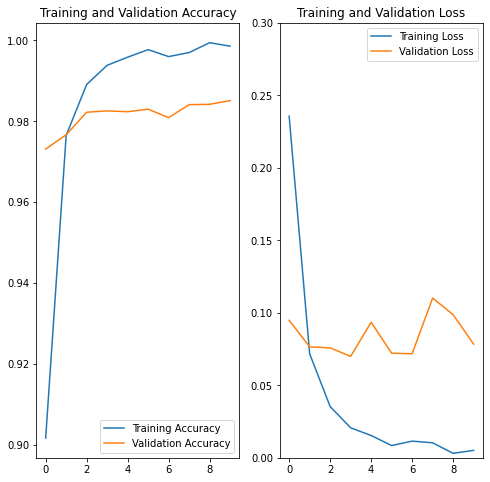

In [17]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylim ([0,0.3])


2. Adding more convolution layers 

In [20]:
model_2 = Sequential([
   layers.Conv2D(16, 3, activation='relu',padding='same', input_shape=(19,19,1)),
   layers.Conv2D(16, 3, activation='relu',padding='same'),
   layers.MaxPooling2D(),

   layers.Conv2D(32, 3, activation='relu',padding='same'),
   layers.Conv2D(32, 3, activation='relu',padding='same'),
   layers.MaxPooling2D(),

    tf.keras.layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation ='sigmoid')
])

In [21]:
model_2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 19, 19, 16)        160       
                                                                 
 conv2d_9 (Conv2D)           (None, 19, 19, 16)        2320      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 9, 9, 16)         0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 9, 9, 32)          4640      
                                                                 
 conv2d_11 (Conv2D)          (None, 9, 9, 32)          9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                  

In [22]:
batch_size = 32
epochs = 10


train_steps = len(train_list) //batch_size
test_steps = len(test_list) //batch_size


history_2 = model_2.fit(train_generator, 
                    epochs = epochs, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps, shuffle=True,
                    callbacks = callbacks_list)

Epoch 1/10
218/218 [==============================] - ETA: 0s - loss: 0.2492 - accuracy: 0.8928
Epoch 1: val_loss did not improve from 0.06996
218/218 [==============================] - 20s 89ms/step - loss: 0.2492 - accuracy: 0.8928 - val_loss: 0.1439 - val_accuracy: 0.9455
Epoch 2/10
217/218 [============================>.] - ETA: 0s - loss: 0.0800 - accuracy: 0.9742
Epoch 2: val_loss did not improve from 0.06996
218/218 [==============================] - 19s 89ms/step - loss: 0.0801 - accuracy: 0.9742 - val_loss: 0.0979 - val_accuracy: 0.9630
Epoch 3/10
218/218 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 0.9907
Epoch 3: val_loss did not improve from 0.06996
218/218 [==============================] - 19s 90ms/step - loss: 0.0317 - accuracy: 0.9907 - val_loss: 0.0779 - val_accuracy: 0.9761
Epoch 4/10
217/218 [============================>.] - ETA: 0s - loss: 0.0150 - accuracy: 0.9947
Epoch 4: val_loss did not improve from 0.06996
218/218 [====================

###Performance figures







(0.0, 0.3)

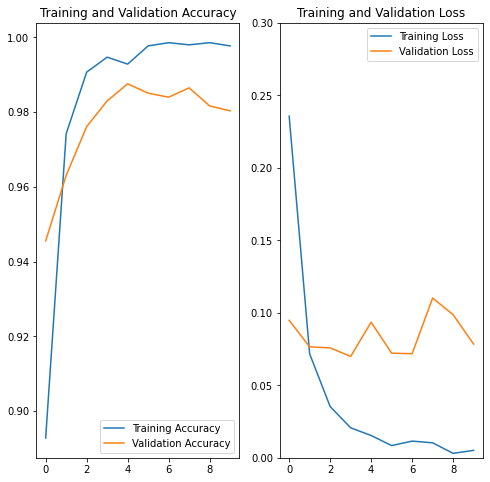

In [23]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylim ([0,0.3])


Adding more parametrs to the model didn't improved it.


##Improving the model by adding augmantation

In [45]:
img_height = 19
img_width = 19


data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  1)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
  ]
)

In [46]:
model_aug = Sequential([
   data_augmentation,
   layers.Conv2D(16, 3, activation='relu',padding = 'same', input_shape=(19,19,1)),
   layers.MaxPooling2D(),

   layers.Conv2D(32, 3, activation='relu',padding = 'same'),
   layers.MaxPooling2D(),

    tf.keras.layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation ='sigmoid')
])

In [47]:
model_aug.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model_aug.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 19, 19, 1)         0         
                                                                 
 conv2d_18 (Conv2D)          (None, 19, 19, 16)        160       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 9, 9, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 9, 9, 32)          4640      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 4, 4, 32)         0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 4, 4, 32)         

In [41]:
#Add checkpoints 
from keras.callbacks import ModelCheckpoint

filepath = 'my_best_model_aug.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'

checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True,save_weights_only=True)
callbacks_list = [checkpoint]

In [48]:
batch_size = 32
epochs = 50

train_steps = len(train_list) //batch_size
test_steps = len(test_list) //batch_size


history_aug = model_aug.fit(train_generator, 
                    epochs = epochs, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps, shuffle=True,
                    callbacks = callbacks_list)

Epoch 1/50
216/218 [============================>.] - ETA: 0s - loss: 0.5048 - accuracy: 0.7555
Epoch 1: val_loss did not improve from 0.07231
218/218 [==============================] - 15s 62ms/step - loss: 0.5031 - accuracy: 0.7570 - val_loss: 0.4988 - val_accuracy: 0.7770
Epoch 2/50
217/218 [============================>.] - ETA: 0s - loss: 0.3353 - accuracy: 0.8566
Epoch 2: val_loss did not improve from 0.07231
218/218 [==============================] - 14s 65ms/step - loss: 0.3349 - accuracy: 0.8568 - val_loss: 0.1895 - val_accuracy: 0.9437
Epoch 3/50
216/218 [============================>.] - ETA: 0s - loss: 0.2933 - accuracy: 0.8776
Epoch 3: val_loss did not improve from 0.07231
218/218 [==============================] - 15s 68ms/step - loss: 0.2932 - accuracy: 0.8774 - val_loss: 0.1705 - val_accuracy: 0.9504
Epoch 4/50
217/218 [============================>.] - ETA: 0s - loss: 0.2653 - accuracy: 0.8900
Epoch 4: val_loss did not improve from 0.07231
218/218 [====================

###**Performance figures**
Model with augmantation

Text(0.5, 1.0, 'Training and Validation Loss')

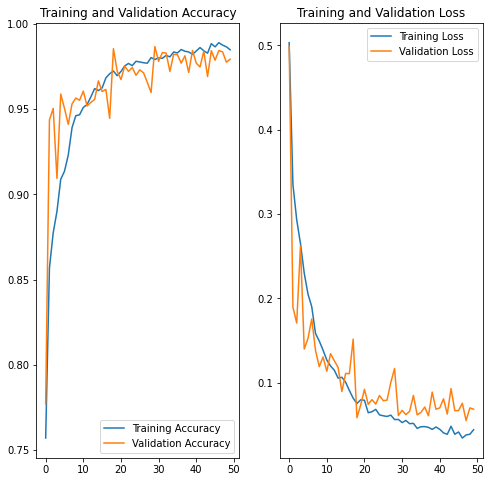

In [49]:
acc = history_aug.history['accuracy']
val_acc = history_aug.history['val_accuracy']

loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')



In [50]:
print("Test_Accuracy: {:.2f}%".format(model_aug.evaluate(np.array(x_test), np.array(y_test))[1]*100))

752/752 [==============================] - 4s 6ms/step - loss: 0.0621 - accuracy: 0.9810
Test_Accuracy: 98.10%


Accuracy results

In [51]:
y_pred = model_aug.predict(x_test)
print (y_pred.shape)

752/752 [==============================] - 4s 6ms/step
(24045, 1)


In [52]:
y_pred[y_pred>=0.5] = 1
y_pred[y_pred<0.5] = 0

num_zeros = (y_pred == 0).sum()
num_ones = (y_pred == 1).sum()

print(num_zeros)
print (num_ones)



23499
546


In [53]:
tp, fn, fp, tn = confusion_matrix(y_test,y_pred,labels=[1,0]).reshape(-1)
print("tp", tp, "fn", fn, "fp", fp, "tn", tn)

tp 281 fn 191 fp 265 tn 23308


In [54]:
recall = tp/(tp+fn)
print ("Recall:", recall)

precision  = tp/ (tp + fp)
print ("Precision :", precision)



Recall: 0.5953389830508474
Precision : 0.5146520146520146



Area under the ROC curve: 0.7920486541267048


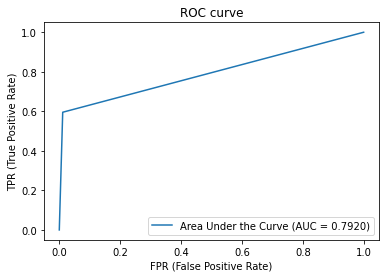

In [55]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve((y_test), y_pred)
AUC_ROC = roc_auc_score(y_test, y_pred)
print ("\nArea under the ROC curve: " +str(AUC_ROC))

roc_curve =plt.figure()
plt.plot(fpr,tpr,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_ROC)
plt.title('ROC curve')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")

## Visualization of the computed featurs

Original Dimensions :  (19, 19)
Resized Dimensions :  (57, 57)


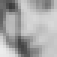

In [ ]:
from google.colab.patches import cv2_imshow


## choosing an image 
img = test_face[0]
img = cv2.imread(img,-1)

## resizing the image 
scale_percent = 300 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

print('Original Dimensions : ',img.shape) 
print('Resized Dimensions : ',resized.shape)
 
cv2_imshow(resized)

In [ ]:
from numpy.lib.shape_base import expand_dims

## convert to array 
img = np.array (img) 
img = np.array(img) / 255.

img = expand_dims(img, axis = (0,3))


In [ ]:
from keras.models import Model

# Define a new model that include the conv layers (without the dense layers)
conv_layer_index = [1, 3]  
outputs = [model_aug.layers[i].output for i in conv_layer_index]
model_short = Model(inputs=model_aug.inputs, outputs=outputs)
print(model_short.summary())



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6_input (InputLa  [(None, 19, 19, 1)]      0         
 yer)                                                            
                                                                 
 sequential_6 (Sequential)   (None, 19, 19, 1)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 16)        160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 6, 6, 32)          4640      
                                                                 
Total params: 4,800
Trainable params: 4,800
Non-trainable p

In [ ]:
feature_maps = model_short.predict(img)

1/1 [==============================] - 0s 50ms/step


Visualize the feature map of the first conv layer (16 filters)

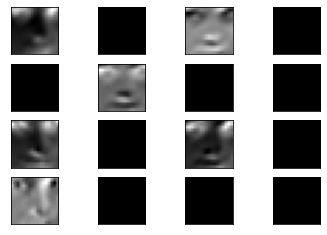

In [ ]:
feature_maps_1 = feature_maps[0]

columns = 4
rows = 4
for ftr in feature_maps_1:
    for i in range(1, columns*rows +1):
        fig =plt.subplot(rows, columns, i)
        fig.set_xticks([])  #Turn off axis
        fig.set_yticks([])
        plt.imshow(ftr[ :, :, i-1], cmap='gray')
    plt.show()

Visualize the feature map of the second conv layer (32 filters)

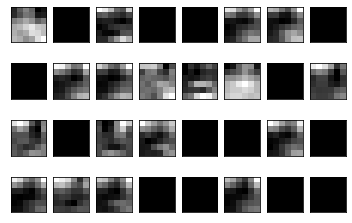

In [ ]:
feature_maps_2 = feature_maps[1]

columns = 8
rows = 4
for ftr in feature_maps_2:
    for i in range(1, columns*rows +1):
        fig =plt.subplot(rows, columns, i)
        fig.set_xticks([])  #Turn off axis
        fig.set_yticks([])
        plt.imshow(ftr[ :, :, i-1], cmap='gray')
    plt.show()